In [1]:
import numpy as np
import os
import urllib
import gzip
import struct
import requests


        
def download_data(url, force_download=False): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        r = requests.get(url, stream=True)
        if r.status_code == 200:
            with open(fname, 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

  
path='http://yann.lecun.com/exdb/mnist/'
train_lbl, train_img = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
val_lbl, val_img = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')








In [2]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);



Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)






<IPython.core.display.Javascript object>

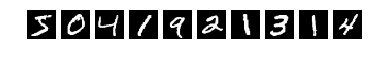

label: [5 0 4 1 9 2 1 3 1 4]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))



In [ ]:
train_img.shape


In [4]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)




```bash
conda install graphviz
pip install graphviz
```

都需要, 前者是 bin 程序, 后者是 python binding, 虽然都叫一个名字

完之后要在 System Path 里添加 `C:\ProgramData\Anaconda3\Library\bin\graphviz`

好让 Python 找到 graphviz 的 bin 程序

完后需要重新开启 shell, 仅仅重启 Jupyter kernel 是不够的



另, 这个路径也是一堆 bin bat, 不知什么用, 不需要添加到 Path `C:\ProgramData\Anaconda3\pkgs\graphviz-2.38.0-4\Library\bin`



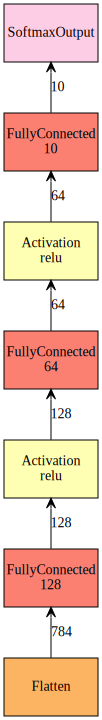

In [5]:
import mxnet as mx
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden=64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, 
# note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)



In [6]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 27742.05 samples/sec	Train-accuracy=0.116300
INFO:root:Epoch[0] Batch [400]	Speed: 28333.55 samples/sec	Train-accuracy=0.109650
INFO:root:Epoch[0] Batch [600]	Speed: 22361.90 samples/sec	Train-accuracy=0.223950
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.350
INFO:root:Epoch[0] Validation-accuracy=0.472100
INFO:root:Epoch[1] Batch [200]	Speed: 27839.26 samples/sec	Train-accuracy=0.611200
INFO:root:Epoch[1] Batch [400]	Speed: 27917.14 samples/sec	Train-accuracy=0.799100
INFO:root:Epoch[1] Batch [600]	Speed: 26560.29 samples/sec	Train-accuracy=0.843800
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=2.201
INFO:root:Epoch[1] Validation-accuracy=0.863800
INFO:root:Epoch[2] Batch [200]	Speed: 28700.46 samples/sec	Train-accuracy=0.868600
INFO:root:Epoch[2] Batch [400]	Speed: 29660.66 samples/sec	Train-accuracy=0.893500
INFO:root:Epoch[2] Batch [600]	Speed: 29793.5

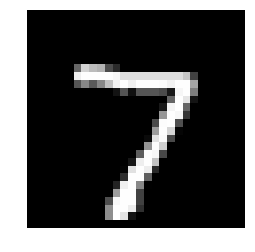

Classified as 7 with probability 0.999477


In [7]:
# After training is done, we can predict a single image.

plt.imshow(val_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]
assert max(prob) > 0.99, "Low prediction accuracy."
print ('Classified as %d with probability %f' % (prob.argmax(), max(prob)))

In [8]:
# We can also evaluate the accuracy given a data iterator.

valid_acc = model.score(val_iter)
print ('Validation accuracy: %f%%' % (valid_acc *100,))
assert valid_acc > 0.95, "Low validation accuracy."

Validation accuracy: 97.040000%


In [10]:
model.score(train_iter)

0.98096666666666665

In [12]:
from IPython.display import HTML
import cv2
import numpy as np

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1,1,28,28))/255.0
    return model.predict(img)[0].argmax()

'''
To see the model in action, run the demo notebook at
https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb.
'''
HTML(filename="mnist_demo.html")

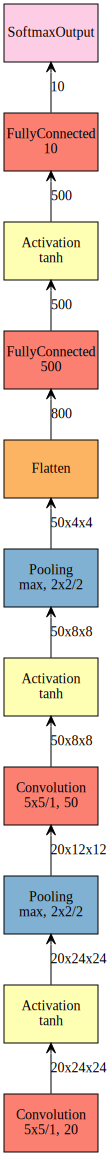

In [13]:
# Convolutional Neural Networks

data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
mx.viz.plot_network(symbol=lenet, shape=shape)

In [14]:
# Note that LeNet is more complex than the previous multilayer perceptron,
# so we use GPU instead of CPU for training.


model = mx.model.FeedForward(
    # ctx = mx.gpu(0),     
    # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
assert model.score(val_iter) > 0.98, "Low validation accuracy."



# 教程的 CPU 没我快, 
# 之前每个 epoch 他们 CPU 2.7 秒, 我用 CPU 2.3 秒

# 但他们显卡真好啊,
# 这里平均每个 epoch 他们显卡 2.6 秒, 我用 CPU 需要 82 秒

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 702.05 samples/sec	Train-accuracy=0.116500
INFO:root:Epoch[0] Batch [400]	Speed: 691.80 samples/sec	Train-accuracy=0.109650
INFO:root:Epoch[0] Batch [600]	Speed: 735.17 samples/sec	Train-accuracy=0.110450
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=84.696
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [200]	Speed: 726.59 samples/sec	Train-accuracy=0.138400
INFO:root:Epoch[1] Batch [400]	Speed: 737.08 samples/sec	Train-accuracy=0.791500
INFO:root:Epoch[1] Batch [600]	Speed: 714.08 samples/sec	Train-accuracy=0.915600
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=82.735
INFO:root:Epoch[1] Validation-accuracy=0.936900


KeyboardInterrupt: 